## Download Dataset

In [7]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


## Imports & Setup

In [8]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchsummary import summary

from sklearn.preprocessing import LabelEncoder


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Preprocessing

In [9]:
image_path = []
labels = []

for i in os.listdir("animal-faces/afhq"):
    for label in os.listdir(f"animal-faces/afhq/{i}"):
        for image in os.listdir(f"animal-faces/afhq/{i}/{label}"):
            image_path.append(f"animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)

df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
df.head()

,image_path,labels
0,animal-faces/afhq/val/dog/flickr_dog_000054.jpg,dog
1,animal-faces/afhq/val/dog/flickr_dog_000640.jpg,dog
2,animal-faces/afhq/val/dog/pixabay_dog_003709.jpg,dog
3,animal-faces/afhq/val/dog/pixabay_dog_002151.jpg,dog
4,animal-faces/afhq/val/dog/pixabay_dog_002979.jpg,dog


## Data Visualization

In [10]:
print(f"Labels: {list(df["labels"].unique())}")

Labels: ['dog', 'wild', 'cat']


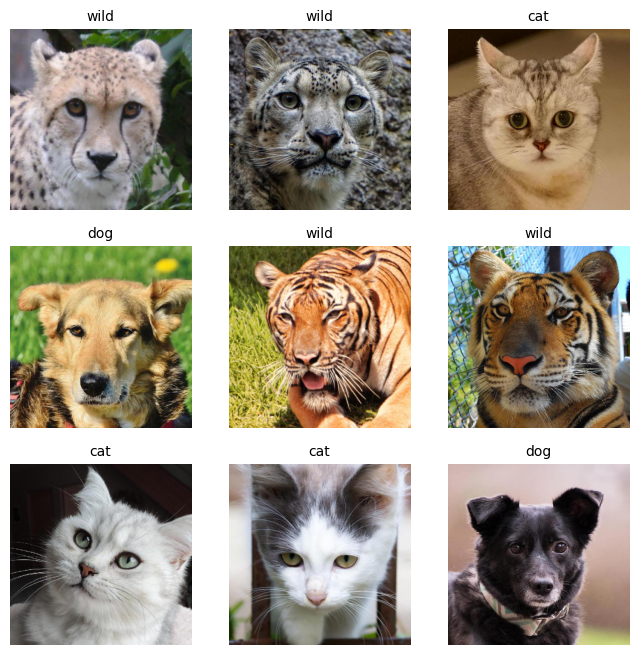

In [11]:
n_rows = 3
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))
for row in range(n_rows):
    for col in range(n_cols):
        sample = df.sample(n=1).iloc[0]
        image = Image.open(sample["image_path"]).convert("RGB")
        label = sample["labels"]
        axs[row, col].imshow(image)
        axs[row, col].set_title(label, fontsize=10)
        axs[row, col].axis("off")
plt.show()

## Train / Val / Test Split

In [12]:
train = df.sample(frac=0.7, random_state=42)
valtest = df.drop(train.index)
val = valtest.sample(frac=0.5, random_state=42)
test = valtest.drop(val.index)

print(f"Train dataset shape: {train.shape}")
print(f"Val dataset shape: {val.shape}")
print(f"Test dataset shape: {test.shape}")

Train dataset shape: (11291, 2)
Val dataset shape: (2420, 2)
Test dataset shape: (2419, 2)


## Image Transformations & Augmentations

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomRotation(15),      
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Dataset & DataLoader

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(df["labels"])


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["labels"]), dtype=torch.long)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["image_path"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
    
        label = self.labels[idx]
        return image, label

In [15]:
train_dataset = CustomImageDataset(train, transform=transform_train)
val_dataset = CustomImageDataset(val, transform=transform_val_test)
test_dataset = CustomImageDataset(test, transform=transform_val_test)

In [16]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

## Model 

In [ ]:
class AnimalFacesCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128, 128)
        self.output = nn.Linear(128, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pooling(x)

        x = self.gap(x)
        x = self.flatten(x) 
        x = self.linear(x)
        x = self.output(x)
        return x 
        

In [18]:
model = AnimalFacesCNN(n_classes=df["labels"].nunique()).to(device)

In [19]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
              ReLU-2         [-1, 32, 126, 126]               0
         MaxPool2d-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 61, 61]          18,496
              ReLU-5           [-1, 64, 61, 61]               0
         MaxPool2d-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
              ReLU-8          [-1, 128, 28, 28]               0
         MaxPool2d-9          [-1, 128, 14, 14]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
           Linear-13                    [-1, 3]             387
Total params: 110,147
Trainable params:

## Training & Evaluation

In [20]:
LR = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [21]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

EPOCHS = 10
for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss_train += loss.item()

        acc = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_acc_train += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss_val += loss.item()

            acc = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_acc_val += acc
            
    total_loss_train_plot.append(round(total_loss_train/len(train_loader), 4))
    total_loss_validation_plot.append(round(total_loss_val/len(val_loader), 4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset), 4))
    total_acc_validation_plot.append(round(total_acc_val/len(val_dataset), 4))

    print(f"""Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/len(train_loader), 4)}, Train Accuracy: {round(total_acc_train/len(train_dataset), 4)}
                Val Loss: {round(total_loss_val/len(val_loader), 4)}, Val Accuracy: {round(total_acc_val/len(val_dataset), 4)}""")
    

Epoch 1/10, Train Loss: 0.9522, Train Accuracy: 0.5007
                Val Loss: 0.8728, Val Accuracy: 0.526
Epoch 2/10, Train Loss: 0.8695, Train Accuracy: 0.5643
                Val Loss: 0.8405, Val Accuracy: 0.5955
Epoch 3/10, Train Loss: 0.8233, Train Accuracy: 0.603
                Val Loss: 0.7911, Val Accuracy: 0.6273
Epoch 4/10, Train Loss: 0.7775, Train Accuracy: 0.6415
                Val Loss: 0.7745, Val Accuracy: 0.6318
Epoch 5/10, Train Loss: 0.7441, Train Accuracy: 0.6606
                Val Loss: 0.7526, Val Accuracy: 0.6496
Epoch 6/10, Train Loss: 0.718, Train Accuracy: 0.6757
                Val Loss: 0.7118, Val Accuracy: 0.6835
Epoch 7/10, Train Loss: 0.6984, Train Accuracy: 0.6914
                Val Loss: 0.7181, Val Accuracy: 0.6798
Epoch 8/10, Train Loss: 0.685, Train Accuracy: 0.7052
                Val Loss: 0.7091, Val Accuracy: 0.6818
Epoch 9/10, Train Loss: 0.6623, Train Accuracy: 0.7187
                Val Loss: 0.6632, Val Accuracy: 0.7157
Epoch 10/10, T

## Testing

In [22]:
model.eval()
test_loss = 0
test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == labels).sum().item()

test_loss /= len(test_loader)
test_acc = test_correct / len(test_dataset) * 100
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.6485, Test Acc: 72.05%


## Model Performance Visualization

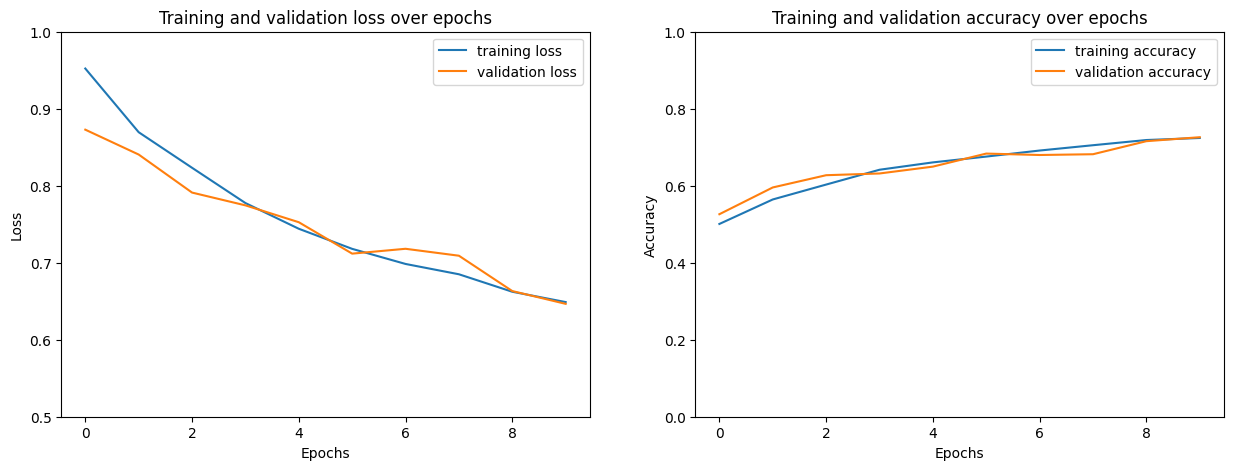

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="training loss")
axs[0].plot(total_loss_validation_plot, label="validation loss")
axs[0].set_title("Training and validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0.5, 1.0])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="training accuracy")
axs[1].plot(total_acc_validation_plot, label="validation accuracy")
axs[1].set_title("Training and validation accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0.0, 1.0])
axs[1].legend()

plt.show()